# Transfer Learning

In this tutorial I trained a convolutional neural network for image classification using transfer learning based on the ***AlexNet***, ***VGG***, ***Inception***, and ***ResNet-18*** models.



According to [cs231](https://cs231n.github.io/transfer-learning/):
> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

According to [TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL
](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), These two major transfer learning scenarios look as follows:

>* ***Finetuning the convnet:*** Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
* ***ConvNet as fixed feature extractor:*** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

## Import all the stuff

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()

## Load Data

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/Transfer Learning Tutorial/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
print(dataset_sizes)

{'train': 244, 'val': 153}


## Visualize Some Data

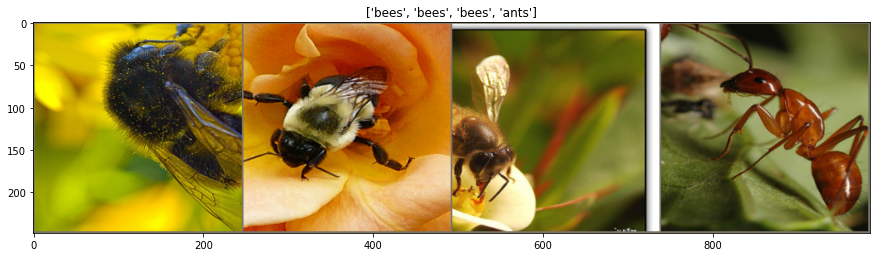

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
for i in dataloaders['train']:
    print(i[0][0])
    break 

tensor([[[ 1.5810,  1.5297,  1.5810,  ...,  1.3070,  1.2557,  1.2214],
         [ 1.5468,  1.5297,  1.6153,  ...,  1.2557,  1.2385,  1.2214],
         [ 1.5297,  1.5468,  1.6153,  ...,  1.2385,  1.2557,  1.2557],
         ...,
         [ 1.3413,  1.2385,  1.1700,  ...,  1.7523,  1.7523,  1.7180],
         [ 1.2728,  1.2214,  1.2043,  ...,  1.7352,  1.6495,  1.7009],
         [ 1.2214,  1.2214,  1.2557,  ...,  1.6667,  1.5810,  1.6667]],

        [[ 0.2402,  0.1001,  0.1176,  ...,  0.3627,  0.2577,  0.2402],
         [ 0.2227,  0.1352,  0.1702,  ...,  0.2577,  0.2227,  0.2402],
         [ 0.1877,  0.1877,  0.2052,  ...,  0.2227,  0.2577,  0.2752],
         ...,
         [ 0.0476, -0.0224, -0.1450,  ...,  1.0630,  1.0630,  1.0455],
         [-0.0224, -0.0574, -0.1275,  ...,  1.0105,  0.9230,  0.9580],
         [ 0.0126,  0.0126, -0.0574,  ...,  0.8880,  0.8354,  0.9230]],

        [[-1.0027, -1.1073, -1.1596,  ..., -1.1596, -1.2293, -1.2641],
         [-1.0724, -1.1073, -1.1596,  ..., -1

## Train Model

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, losses

## Evaluate Model

In [7]:
def evaluate(model):
    model.train(False)

    running_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data

        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        else:
            inputs, labels = inputs, labels

        output = model(inputs)
        _, predicted = torch.max(output, 1)
        print(torch.sum(predicted == labels))
        
        running_correct += int(torch.sum(predicted == labels))
        
    return running_correct / dataset_sizes['val']

## AlexNet

### Train the model using the AlexNet model architecture

In [8]:
model = models.alexnet(pretrained=True)

In [9]:
num_features = 4096

model.classifier[6] = nn.Linear(num_features, 2)

if use_gpu:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1634 Acc: 0.7336
val Loss: 0.1274 Acc: 0.7974

Epoch 1/24
----------
train Loss: 0.1411 Acc: 0.7541
val Loss: 0.1075 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.1452 Acc: 0.7131
val Loss: 0.1453 Acc: 0.7190

Epoch 3/24
----------
train Loss: 0.1281 Acc: 0.7336
val Loss: 0.1308 Acc: 0.7190

Epoch 4/24
----------
train Loss: 0.1078 Acc: 0.7869
val Loss: 0.1253 Acc: 0.7974

Epoch 5/24
----------
train Loss: 0.0796 Acc: 0.8689
val Loss: 0.1450 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.1122 Acc: 0.8156
val Loss: 0.0928 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.0641 Acc: 0.8893
val Loss: 0.0977 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.0487 Acc: 0.9016
val Loss: 0.0871 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.0535 Acc: 0.8934
val Loss: 0.0912 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.0455 Acc: 0.9139
val Loss: 0.1001 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.0341 Acc: 0.9426
val Loss: 0.1015 Acc: 0.8954

Ep

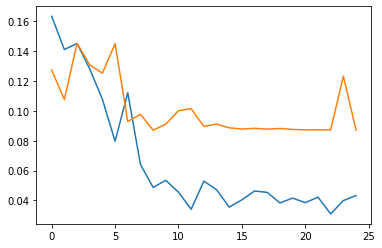

In [12]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [13]:
torch.save(model.state_dict(), 'AlexNet_model.pth')

In [14]:
model.load_state_dict(torch.load('AlexNet_model.pth'))

<All keys matched successfully>

In [15]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
t

### AlexNet as a fixed feature extactor

In [16]:
model_extractor = models.alexnet(pretrained=True)

In [17]:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [18]:
for param in model_extractor.features.parameters():
    param.requires_grad = False
    
num_features = 4096
model_extractor.classifier[6] = nn.Linear(num_features, 2)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
%%time
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1547 Acc: 0.8320
val Loss: 0.3034 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.2280 Acc: 0.8361
val Loss: 0.1907 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.1009 Acc: 0.9139
val Loss: 0.1506 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.1025 Acc: 0.9180
val Loss: 0.1171 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.0857 Acc: 0.8934
val Loss: 0.1229 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.0522 Acc: 0.9303
val Loss: 0.1391 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.0712 Acc: 0.9098
val Loss: 0.1464 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.0564 Acc: 0.9262
val Loss: 0.1093 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.0233 Acc: 0.9631
val Loss: 0.1060 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.0222 Acc: 0.9672
val Loss: 0.1006 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.0389 Acc: 0.9590
val Loss: 0.0982 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.0234 Acc: 0.9672
val Loss: 0.0961 Acc: 0.8954

Ep

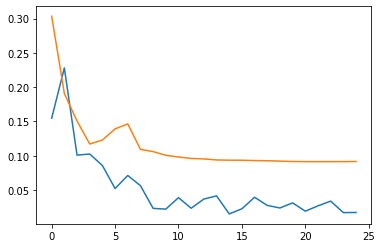

In [20]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [21]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [22]:
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

<All keys matched successfully>

In [23]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
t

### Finetuning the AlexNet

In [24]:
model_mixed = models.alexnet(pretrained=True)

In [25]:
model_mixed

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
layers_to_unfreeze = 5
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 4096
model_mixed.classifier[6] = nn.Linear(num_features, 2)
if use_gpu:
    model_mixed = model_mixed.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [27]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.1625 Acc: 0.7992
val Loss: 0.0954 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.0719 Acc: 0.8689
val Loss: 0.0709 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.0584 Acc: 0.9057
val Loss: 0.0789 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.0383 Acc: 0.9344
val Loss: 0.0930 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.0773 Acc: 0.9016
val Loss: 0.0955 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.0329 Acc: 0.9590
val Loss: 0.0869 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.0287 Acc: 0.9631
val Loss: 0.0791 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.0275 Acc: 0.9672
val Loss: 0.0798 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.0151 Acc: 0.9713
val Loss: 0.0759 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.0157 Acc: 0.9754
val Loss: 0.0735 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.0323 Acc: 0.9549
val Loss: 0.0732 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.0176 Acc: 0.9836
val Loss: 0.0737 Acc: 0.9150

Ep

In [28]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')


In [29]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))


<All keys matched successfully>

In [30]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))


tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
t

## VGG16

In [31]:
model_extractor = models.vgg16(pretrained=True)

In [32]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
for i in model_extractor.features:
    print(i, end=" ")
    for param in i.parameters():
        print(param.requires_grad, end=" ")
    print()

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True True 
ReLU(inplace=True) 
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True True 
ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True True 
ReLU(inplace=True) 
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True True 
ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True True 
ReLU(inplace=True) 
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True True 
ReLU(inplace=True) 
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True True 
ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True True 
ReLU(i

In [34]:
for param in model_extractor.features.parameters():
    param.requires_grad = False

num_features = 4096

model_extractor.classifier[6] = nn.Linear(num_features, 2)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [35]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
for i in model_extractor.features:
    print(i, end=" ")
    for param in i.parameters():
        print(param.requires_grad, end=" ")
    print()

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) Fal

In [37]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0691 Acc: 0.8770
val Loss: 0.0304 Acc: 0.9739

Epoch 1/24
----------
train Loss: 0.0398 Acc: 0.9385
val Loss: 0.0395 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.0509 Acc: 0.9426
val Loss: 0.0627 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.0630 Acc: 0.8975
val Loss: 0.0778 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.0919 Acc: 0.9180
val Loss: 0.0805 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.0330 Acc: 0.9549
val Loss: 0.0504 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.0378 Acc: 0.9549
val Loss: 0.0494 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.0302 Acc: 0.9672
val Loss: 0.0364 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.0176 Acc: 0.9672
val Loss: 0.0372 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.0261 Acc: 0.9549
val Loss: 0.0345 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0186 Acc: 0.9713
val Loss: 0.0350 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0190 Acc: 0.9795
val Loss: 0.0345 Acc: 0.9477

Ep

In [38]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [39]:
model_extractor.load_state_dict(torch.load('VGG16.pth'))

<All keys matched successfully>

In [40]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))


tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
t

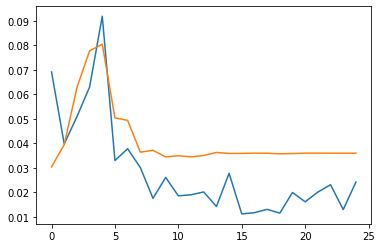

In [41]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [42]:
model_mixed = models.vgg16(pretrained=True)

In [43]:
model_mixed

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
layers_to_unfreeze = 7
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 4096

model_mixed.classifier[6] = nn.Linear(num_features, 2)

if use_gpu:
    model_mixed = model_mixed.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
for i in model_mixed.features:
    print(i, end=" ")
    for param in i.parameters():
        print(param.requires_grad, end=" ")
    print()

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False False 
ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) Fal

In [46]:
%%time
model_mixed, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0792 Acc: 0.8525
val Loss: 0.0423 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.0484 Acc: 0.9344
val Loss: 0.0681 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.0300 Acc: 0.9467
val Loss: 0.0469 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.0226 Acc: 0.9631
val Loss: 0.0582 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.0360 Acc: 0.9549
val Loss: 0.0454 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.0297 Acc: 0.9549
val Loss: 0.0477 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.0259 Acc: 0.9508
val Loss: 0.0793 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.0083 Acc: 0.9918
val Loss: 0.0536 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.0110 Acc: 0.9877
val Loss: 0.0504 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.0102 Acc: 0.9836
val Loss: 0.0473 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.0180 Acc: 0.9713
val Loss: 0.0410 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0097 Acc: 0.9836
val Loss: 0.0465 Acc: 0.9542

Ep

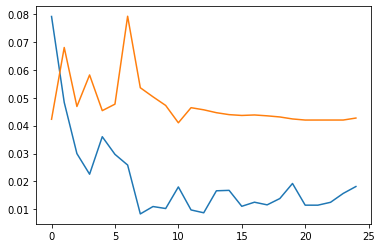

In [47]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [48]:
torch.save(model_mixed.state_dict(), 'VGG16_mixed.pth')

In [49]:
model_mixed.load_state_dict(torch.load('VGG16_mixed.pth'))

<All keys matched successfully>

In [50]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))


tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
t

## Inception_v3

In [51]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}

In [52]:
model_extractor = models.inception_v3(pretrained=True)

In [53]:
model_extractor

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [54]:
for param in model_extractor.parameters():
    param.requires_grad = False

num_features = 2048

model_extractor.fc = nn.Linear(num_features, 2)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_extractor.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [55]:
%%time
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1588 Acc: 0.6270
val Loss: 0.0989 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.1396 Acc: 0.7172
val Loss: 0.0767 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.1321 Acc: 0.7377
val Loss: 0.0657 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.1071 Acc: 0.8197
val Loss: 0.0708 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.0989 Acc: 0.8361
val Loss: 0.0661 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.1070 Acc: 0.7992
val Loss: 0.0604 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.1021 Acc: 0.8115
val Loss: 0.0589 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.1084 Acc: 0.8074
val Loss: 0.0511 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.1026 Acc: 0.8115
val Loss: 0.0538 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.1092 Acc: 0.7869
val Loss: 0.0551 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.1082 Acc: 0.8115
val Loss: 0.0561 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.0983 Acc: 0.7992
val Loss: 0.0534 Acc: 0.8954

Ep

In [56]:
torch.save(model_extractor.state_dict(), 'Inceptionv3.pth')

In [57]:
model_extractor.load_state_dict(torch.load('Inceptionv3.pth'))

<All keys matched successfully>

In [58]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
t

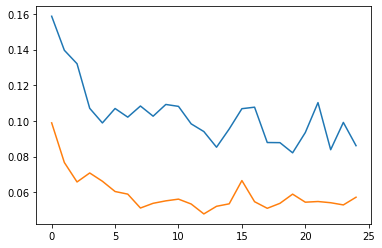

In [59]:
plt.plot(losses['train'])
plt.plot(losses['val'])

## ResNet-18

In [60]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/Transfer Learning Tutorial/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [61]:
feature_extractor = models.resnet18(pretrained=True)

In [62]:
feature_extractor

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
for param in feature_extractor.parameters():
    param.requires_grad = False

num_features = 512

feature_extractor.fc = nn.Linear(num_features, 2)

if use_gpu:
    feature_extractor = feature_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(feature_extractor.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [64]:
%%time
model_extractor, losses = train_model(feature_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1598 Acc: 0.6803
val Loss: 0.0798 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.1713 Acc: 0.7336
val Loss: 0.0510 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.1379 Acc: 0.7500
val Loss: 0.0476 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.1045 Acc: 0.8033
val Loss: 0.0698 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.1147 Acc: 0.7951
val Loss: 0.0471 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.1400 Acc: 0.7746
val Loss: 0.0534 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.0850 Acc: 0.8566
val Loss: 0.0529 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.0902 Acc: 0.8156
val Loss: 0.0523 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.0751 Acc: 0.8811
val Loss: 0.0562 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.0785 Acc: 0.8730
val Loss: 0.0570 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.1019 Acc: 0.8402
val Loss: 0.0506 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0861 Acc: 0.8689
val Loss: 0.0509 Acc: 0.9412

Ep

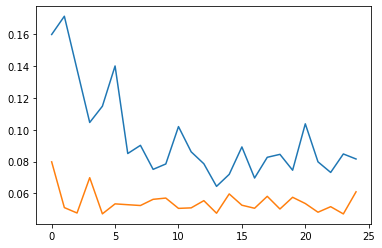

In [65]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [66]:
torch.save(feature_extractor.state_dict(), 'ResNet18.pth')

In [67]:
feature_extractor.load_state_dict(torch.load('ResNet18.pth'))


<All keys matched successfully>

In [68]:
print("Accuracy: {0:.4f}".format(evaluate(feature_extractor)))

tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
t